In [9]:

# a = "/home/s2765918/code-et/results/HRC/test_early_and_late_fusions_new/models/test_early_and_late_fusions_new_fold_2.pt"

In [1]:
from vit import VisionTransformer
import torch.nn.functional as F

import torch
from matplotlib import pyplot as plt
import cv2
from torch import nn
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import matplotlib.pyplot as plt
from trajectory import Trajectory, TrajectoryDataset, extract_fixed_sized_segments, split_into_train_and_test, remove_short_trajectories, get_categories, get_UTK_categories, get_NTU_categories,extract_frames
import pickle
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from einops import rearrange, repeat
from transformer import TubeletTemporalSpatialPart_concat_chan_2_Transformer, \
                TubeletTemporalPart_concat_chan_1_Transformer, TubeletTemporalTransformer, \
                TubeletTemporalPart_mean_chan_1_Transformer, TubeletTemporalPart_mean_chan_2_Transformer,\
                 TubeletTemporalPart_concat_chan_2_Transformer, TemporalTransformer_4, \
                 TemporalTransformer_3, TemporalTransformer_2, BodyPartTransformer, \
                 SpatialTemporalTransformer, TemporalTransformer, Block, Attention, Mlp, ensemble,vit_model

/home/s2765918/miniconda3/envs/copy_of_open-mmlab/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:


#Load test trajectories
PIK = "/home/s2765918/code-et/code/data/HRC/trajectories_train_HRC_2D.dat"


with open(PIK, "rb") as f:
    trajectories = pickle.load(f)

Taking a sample of the data

In [3]:
train_size =0.01
test_size=0.01
train_crime_trajectories_new ={}
test_crime_trajectories_new = {}
idx_filemap = {i:k for i,k in enumerate(trajectories)}
splitter = StratifiedShuffleSplit(n_splits=1,train_size=train_size,test_size=test_size,random_state=1)

all_labels = [v.category for k,v in trajectories.items()]
split_labels_train = []
split_labels_test = []
for x,y in splitter.split(trajectories,all_labels):
    for i in x:
        train_crime_trajectories_new[idx_filemap[i]] = trajectories[idx_filemap[i]]
        # split_labels_train.append(all_labels[i])

    for j in y:
        test_crime_trajectories_new[idx_filemap[j]] = trajectories[idx_filemap[j]]
        # split_labels_test.append(all_labels[j])

train_crime_trajectories = train_crime_trajectories_new

test_crime_trajectories = test_crime_trajectories_new

In [4]:
train_crime_trajectories = remove_short_trajectories(trajectories, input_length=20, input_gap=0, pred_length=0)
# test_crime_trajectories = remove_short_trajectories(trajectories, input_length=20, input_gap=0, pred_length=0)

In [5]:
train = TrajectoryDataset(*extract_fixed_sized_segments("HRC", train_crime_trajectories, input_length=20))
# test = TrajectoryDataset(*extract_fixed_sized_segments("HRC", test_crime_trajectories, input_length=20))

list of ids
3493623


In [21]:
idx = 900

In [22]:
coords = train[idx]["coordinates"][len(train[idx]["coordinates"])//2]

In [23]:
x_values = coords[1::2]
y_values = coords[2::2]

In [24]:

startcoord_x = int(min(x_values))
startcoord_y = int(min(y_values))

endcoord_x = int(max(x_values))
endcoord_y = int(max(y_values))

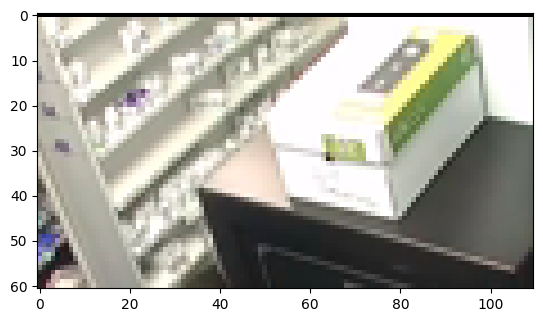

In [25]:
# train[0]["extracted_frames"]
plt.imshow(train[idx]["extracted_frames"][startcoord_y:startcoord_y+endcoord_y, startcoord_x:startcoord_x+endcoord_x])

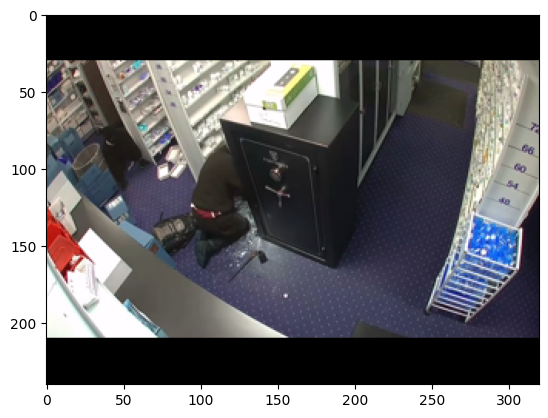

In [26]:
plt.imshow(train[idx]["extracted_frames"])

In [27]:
def collator_for_lists(batch):
    '''
    Reference : https://stackoverflow.com/questions/64883998/pytorch-dataloader-shows-odd-behavior-with-string-dataset
    Reference : https://stackoverflow.com/questions/52818145/why-pytorch-dataloader-behaves-differently-on-numpy-array-and-list
    '''
    # assert all('sentences' in x for x in batch)
    # assert all('label' in x for x in batch)
    
    a = {
        'id': [x['id'] for x in batch],
        'videos': [x['videos'] for x in batch],
        'persons': [x['persons'] for x in batch],
        'frames': torch.tensor(np.array([x['frames'] for x in batch])),
        'categories': torch.tensor(np.array([x['categories'] for x in batch])),
        'coordinates': torch.tensor(np.array([x['coordinates'] for x in batch])),
        # 'extracted_frames': torch.tensor([np.array(i["extracted_frames"]) for i in batch])
        # 'extracted_frames':torch.stack(list(map(lambda x: torch.tensor(x['extracted_frames']), batch))) 
        'extracted_frames':torch.stack(list(map(lambda x: extract_frames(x['id'],x['frames']), batch))) 
    }
    # logger.info(f"Total time to retrieve : {abs(start-time.time())}")
    return a
    

In [7]:
# # model = TubeletTemporalSpatialPart_concat_chan_2_Transformer(dataset="HRC", embed_dim_ratio=64, num_frames=20, num_classes=13, num_joints=17, in_chans=2, kernel=(8,3,3), stride=(8,3,3), mlp_ratio=2., qkv_bias=True, qk_scale=None, dropout=0.1, pad_mode = "constant",embed_dim_final=64,vit_model=None,include_top=True)

# f = TemporalTransformer( num_classes=13, num_frames=20, num_joints=17, in_chans=2, embed_dim=64, depth=4,
#                  num_heads=8, mlp_ratio=2., qkv_bias=True, qk_scale=None,
#                  drop_rate=0., attn_drop_rate=0., dropout=0.2)

num_classes 13
embed_dim 64
in_chans 2
num_joints 17


Creating vision transformer

In [45]:
# model_2 = VisionTransformer(image_size= 224,
#                 patch_size= 8,
#                 num_layers= 1,
#                 num_heads= 6,
#                 hidden_dim= 60,
#                 mlp_dim= 40,
#                 dropout=   0.0,
#                 attention_dropout=   0.0,
#                 num_classes=  64,
#             )

<h3> Implementing cross self attention block</h3>

In [24]:
class Mlp(nn.Module):
    """ MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x
    
class CrossAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.,return_attention=True):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor can be manually set to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.cross_attn_scores = None

    def forward(self, encoder_1,encoder_2): 
        #encoder_1 skeleton trajectories, encoder_2 visual information
        #value = output of model which contains skeleton trajectories, #query and key model which consists of spatial information
        # print(encoder_1.shape)
        # print(encoder_2.shape)
        B, N,C = encoder_1.shape #Batch, segment length, embed dim
      
        q, k, v = encoder_1, encoder_2, encoder_2   # make torchscript happy (cannot use tensor as tuple)
        #torch.Size([1, 100, 64])
        q = q.reshape(B,N,self.num_heads,C//self.num_heads).permute(0,2,1,3) #batch,segment length, num_heads,embed dim/num_head

        k = k.reshape(B,1,self.num_heads,C//self.num_heads).permute(0,2,1,3) #same
        v = k
        # print("reshapoed key ", k.size())
        # print(q.size())
        # B,N,C = encoder_2.shape
        # print(v.size())
        # v = v.squeeze()

        attn = (q @ k.transpose(-2, -1)) * self.scale  # [100, 4, 21, 1]) [100, 4, segment legnth, 1 for each context]) 
        # print(q@k.transpose(-2,-1))
        attn = attn.softmax(dim=2)
        print(attn)
        # print(attn.size())
        attn = self.attn_drop(attn)

        self.cross_attn_scores = attn
        x = ((attn @ v)).reshape(B, N, C)

            
        x = self.proj(x)
        
        x = self.proj_drop(x)

        return x

class CrossAttentionBlock(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 dropout=0., act_layer=nn.GELU):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = CrossAttention(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        #self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.dropout = nn.Dropout(dropout) #first try a simple dropout instead of drop path
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        
    def forward(self, encoder_1,encoder_2):
        #architecture taken from these paper https://arxiv.org/pdf/2204.04564.pdf

        x = self.dropout(self.attn(encoder_1,encoder_2))
        print(encoder_2.size())
        # print(x.size())
        print(x.permute(1,0,2).size())
        x = self.norm2(encoder_2.permute(1,0,2)+x)
        x = self.mlp(x)
        return x
    


In [186]:
ca = nn.ModuleList([
    CrossAttentionBlock(
        dim=64, num_heads=8, mlp_ratio=4., qkv_bias=0, qk_scale=0,
        drop=0.3, attn_drop=0.7, dropout=0.2
        )
    for i in range(4)])

To replace TemporalTransformer or anyother function -- forward function

- To do 
    - Create fusion models for all the types of model(should i?)

In [29]:
import torch.nn.functional as F

In [47]:
class FusionModel_TemporalTransformer(TemporalTransformer):
    def __init__(self,*args,fusion_type="early",cross_attention=True,**kwargs):
        # prin
        # print(True if fusion_type!="el" else False)

        if (fusion_type=="el") or (fusion_type=="l"):
            self.embed_fusion = kwargs["embed_dim"]//2
        else:
            self.embed_fusion = kwargs["embed_dim"] 
        self.fusion=fusion_type
        print(f"Fusion type : '{self.fusion}'")
        # self.embed_fusion = kwargs["embed_dim"] if (fusion_type!="el" or fusion_type!="l") else kwargs["embed_dim"]//2 #Embedding dimesnion is split so that, 64//2 -> 32 for ViT 32 for Temporal transformer

        kwargs["embed_dim"]= self.embed_fusion
        super().__init__(*args, **kwargs)
        
        self.model_2 = VisionTransformer(image_size= 224,
                patch_size= 8,
                num_layers= 1,
                num_heads= 6,
                hidden_dim= 60,
                mlp_dim= 40,
                dropout=   0.0,
                attention_dropout=   0.0,
                num_classes=  self.embed_fusion,
            )

        if (fusion_type=="el") or (fusion_type=="l") :
            self.head = nn.Linear(self.embed_fusion*2,kwargs["num_classes"])
        else:
            self.head = nn.Linear(self.embed_fusion,kwargs["num_classes"])

        self.need_crossattention = cross_attention
        if self.need_crossattention:
    
            self.cross_attention_block =  nn.ModuleList([CrossAttentionBlock(
              self.embed_fusion, num_heads=kwargs["num_heads"], mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 dropout=0., act_layer=nn.GELU
                 #drop_path=dpr[i] #first try a simple dropout instead of drop path
                )     for i in range(4)])
        print(f"Cross Attention Mode :- {self.need_crossattention}")
        # self.head = nn.Linear(self.embed_fusion if (fusion_type!="el") or (fusion_type!="l") else self.embed_fusion*2,kwargs["num_classes"])
        self.fusion_block = None #can be a nn.Sequential() to do the fusion.
        self.classification_block = None
        if self.fusion!=None:
            if self.fusion!="l":
                self.pos_embed = nn.Parameter(torch.zeros(kwargs["num_frames"]+2, kwargs["embed_dim"]))
            else:
                self.pos_embed = nn.Parameter(torch.zeros(kwargs["num_frames"]+1, kwargs["embed_dim"]))
        else:
            self.pos_embed = nn.Parameter(torch.zeros(kwargs["num_frames"]+1, kwargs["embed_dim"]))
        # self.pos_embed = nn.Parameter(torch.zeros(kwargs["num_frames"]+2, kwargs["embed_dim"])) if self.fusion!=None or self.fusion \
        #                                 else nn.Parameter(torch.zeros(kwargs["num_frames"]+1, kwargs["embed_dim"]))  
        self.model_2_output = None 
    def forward_features(self, x,image=None):
        #print("call forward features")
        # print(f"x shape: {x.shape}")

        x = self.embedding(x)
        # print("this")
        # print(x.size())
        if self.fusion!=None:
            img = self.model_2(image).unsqueeze(0)
            if (self.fusion=="el" or self.fusion=="l"):
                self.model_2_output=img
        else:
            if self.need_crossattention:
                img = self.model_2(image).unsqueeze(0)
                self.model_2_output=img
        # print(img.size())
        # print("s")
        #print(f"self cls_token shape: {self.cls_token.shape}")

        #print("expand cls_token")
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)  # stole cls_tokens impl from Phil Wang, thanks

        #print(f"expanded cls_token shape: {cls_token.shape}")
        #print(f"embedded x shape: {x.shape}")

        x = torch.cat((cls_token, x), dim=1)

        # print(x.size())
        if self.fusion is not None:
            if self.fusion!="l":
                img = torch.permute(img,(1,0,2))
                x=torch.cat((x,img),dim=1)
    
        # print(x.size())
        #print(f"embedded x + cls_token shape: {x.shape}")

        #print(f"pos_embed shape: {self.pos_embed.shape}")
        #print(f"x + self.pos_embed shape: {(x + self.pos_embed).shape}")

        x = self.pos_drop(x + self.pos_embed)
        # print(f"pos_drop x shape: {x.shape}")

        #x = self.blocks(x)
        for blk in self.blocks:
            x = blk(x)
            #print(f"blocks(x) shape: {x.shape}")

        x = self.norm(x)
        
        # print("x shape:", x.shape)
     
        # cls_token_final = x[:, 0]
        # print(cls_token_final.size())
        if self.need_crossattention:
            for i in self.cross_attention_block:
                x = i(x,self.model_2_output)
        # else:
        
            
        cls_token_final = x[:, 0]
        # return self.pre_logits(x[:, 0])
        return cls_token_final

    def forward(self,x,image=None):
        if self.fusion=="e": #Early fusion temporal transformer
            x = self.forward_features(x,image)
            x = self.head(x)
            x = F.log_softmax(x, dim=1)
            #do early fusion here
            return x
        if self.fusion=="el": #Early & late fusion transformer
            x = self.forward_features(x,image)
            # print(torch.permute(self.model_2_output,(1,0,2)).size())
            x = torch.concat([x,self.model_2_output.squeeze()],dim=1)
            x = self.head(x)
            x = F.log_softmax(x, dim=1)
            return x

        if self.fusion=="l": #late fusion transformer
            x = self.forward_features(x,image)
            # print(x.size())
            x = torch.concat([x,self.model_2_output.squeeze()],dim=1)
            x = self.head(x)
            x = F.log_softmax(x, dim=1)
            return x

        if self.fusion==None: #Regular temporal transformer
            x = self.forward_features(x,image)
            x = self.head(x)
            x = F.log_softmax(x, dim=1)
            return x

In [44]:
from transformer import FusionModel_TemporalTransformer

In [38]:
del a

In [48]:
a = FusionModel_TemporalTransformer(fusion_type="el",cross_attention=False,num_classes=19, num_frames=20, num_joints=17, in_chans=2, embed_dim=64, depth=4,
                 num_heads=8, mlp_ratio=2., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., dropout=0.2)

Fusion type : 'el'
num_classes 19
embed_dim 32
in_chans 2
num_joints 17
Cross Attention Mode :- False


tensor(1., grad_fn=<SelectBackward0>)

In [31]:
a(torch.randn(20,20,34),torch.randn(20,3,224,224))

tensor([[-3.2685, -3.3172, -3.6428, -2.8567, -2.7413, -3.3953, -2.8196, -2.8450,
         -2.8285, -2.3454, -2.6425, -3.1677, -3.5275, -3.2393, -3.0699, -2.2874,
         -3.1557, -2.7911, -3.2813],
        [-2.3755, -3.8394, -3.6200, -2.9607, -2.4980, -3.1940, -3.2129, -2.7612,
         -3.0042, -2.6072, -2.7807, -2.6524, -3.6439, -3.8429, -2.4300, -2.7103,
         -3.0699, -3.2833, -3.2603],
        [-2.9358, -3.1262, -3.2602, -2.6833, -2.4165, -3.3060, -3.7240, -3.3004,
         -3.2226, -2.7426, -2.8945, -2.8052, -2.9201, -3.6669, -2.8654, -2.4479,
         -2.8370, -3.0816, -2.7818],
        [-3.1745, -2.9692, -3.5294, -2.6212, -2.6959, -2.9899, -3.0429, -3.2691,
         -3.0472, -2.4438, -2.7636, -3.5127, -3.1005, -3.6902, -2.1922, -2.6749,
         -3.1959, -3.1913, -3.1829],
        [-2.1312, -3.5219, -3.7208, -2.9574, -2.6302, -3.2368, -3.7010, -2.6833,
         -3.3975, -2.8371, -3.4432, -2.8073, -3.4946, -3.8374, -3.0063, -2.5615,
         -2.7989, -2.9851, -2.3347],
     

In [32]:
img = torch.randn(100,3,224,224)
coordinates= torch.Tensor(train[:100]["coordinates"])
print(coordinates.size())


AttributeError: 'list' object has no attribute 'split'

In [50]:
k = torch.randn(100,4,21,16)
i = torch.randn(100,4,16,1)

In [51]:
s = k@i

In [36]:
s.size()

torch.Size([100, 4, 21, 1])

In [32]:
(s@torch.randn(100,4,16,1).transpose(-2,-1)).size()

torch.Size([100, 4, 21, 16])

In [38]:
a(coordinates,img)

torch.Size([100, 8, 21, 1])
torch.Size([1, 100, 64])
torch.Size([21, 100, 64])
torch.Size([100, 8, 21, 1])
torch.Size([1, 100, 64])
torch.Size([21, 100, 64])
torch.Size([100, 8, 21, 1])
torch.Size([1, 100, 64])
torch.Size([21, 100, 64])
torch.Size([100, 8, 21, 1])
torch.Size([1, 100, 64])
torch.Size([21, 100, 64])


tensor([[-3.1024, -2.7269, -3.0707,  ..., -3.0425, -2.8276, -2.8210],
        [-3.1024, -2.7269, -3.0707,  ..., -3.0425, -2.8276, -2.8210],
        [-3.1024, -2.7269, -3.0707,  ..., -3.0425, -2.8276, -2.8210],
        ...,
        [-3.1024, -2.7269, -3.0707,  ..., -3.0425, -2.8276, -2.8210],
        [-3.1024, -2.7269, -3.0707,  ..., -3.0425, -2.8276, -2.8210],
        [-3.1024, -2.7269, -3.0707,  ..., -3.0425, -2.8276, -2.8210]],
       grad_fn=<LogSoftmaxBackward0>)

In [76]:
img = torch.randn(100,3,224,224)
coordinates= torch.Tensor(train[:100]["coordinates"])
print(coordinates.size())

torch.Size([100, 20, 34])


In [67]:
coordinates.size()

torch.Size([100, 20, 34])

Trying to get and visualize attention weights ViT PyTorch implementation

In [118]:
path ="/home/s2765918/code-et/results/HRC/crossattentioncontssextssssfix_6611_fusion_1_temporal_32222_with_attention/models/crossattentioncontssextssssfix_6611_fusion_1_temporal_32222_with_attention_fold_2.pt"

In [119]:
model_l = torch.load(path,map_location="cpu")

In [120]:
attention = model_l.cross_attention_block.attn.cross_attn_scores

<h4>Visualizing images</h4>

In [121]:
train_dataloader = torch.utils.data.DataLoader(train, batch_size = 100, shuffle=True, collate_fn=collator_for_lists,num_workers=24,pin_memory=True,persistent_workers=True)


In [122]:
data_test = next(iter(train_dataloader))
coordinates, frames = data_test["coordinates"],data_test["extracted_frames"]
frames_test = frames.permute(0,3,1,2) 

In [44]:
frames_test.size()

torch.Size([1, 3, 224, 224])

In [51]:
model_l(coordinates,frames_test)

torch.Size([100, 8, 21, 1])
torch.Size([1, 100, 64])
torch.Size([21, 100, 64])
torch.Size([100, 8, 21, 1])
torch.Size([1, 100, 64])
torch.Size([21, 100, 64])
torch.Size([100, 8, 21, 1])
torch.Size([1, 100, 64])
torch.Size([21, 100, 64])
torch.Size([100, 8, 21, 1])
torch.Size([1, 100, 64])
torch.Size([21, 100, 64])


tensor([[-3.1024, -2.7269, -3.0707,  ..., -3.0425, -2.8276, -2.8210],
        [-3.1024, -2.7269, -3.0707,  ..., -3.0425, -2.8276, -2.8210],
        [-3.1024, -2.7269, -3.0707,  ..., -3.0425, -2.8276, -2.8210],
        ...,
        [-3.1024, -2.7269, -3.0707,  ..., -3.0425, -2.8276, -2.8210],
        [-3.1024, -2.7269, -3.0707,  ..., -3.0425, -2.8276, -2.8210],
        [-3.1024, -2.7269, -3.0707,  ..., -3.0425, -2.8276, -2.8210]],
       grad_fn=<LogSoftmaxBackward0>)

In [26]:
coordinates.size()

torch.Size([1, 20, 34])

In [123]:
model_l(coordinates,frames_test)

torch.Size([100, 4, 21, 1])


tensor([[-8.4659e+00, -1.0426e+01, -1.5241e+01,  ..., -1.1698e-02,
         -9.8242e+00, -8.2425e+00],
        [-5.4020e+00, -6.8446e+00, -5.5186e+00,  ..., -5.3354e+00,
         -7.3955e+00, -3.0865e+00],
        [-1.9955e+00, -5.3131e+00, -4.7221e+00,  ..., -4.9422e+00,
         -9.4851e+00, -4.0214e+00],
        ...,
        [-6.0807e+00, -9.4037e+00, -4.9908e+00,  ..., -6.5065e+00,
         -4.4945e-01, -9.4815e+00],
        [-6.2258e+00, -9.1342e+00, -5.6422e+00,  ..., -8.2234e+00,
         -5.5142e+00, -9.4864e+00],
        [-5.9454e+00, -7.9641e+00, -1.3932e+01,  ..., -9.0896e-03,
         -1.0773e+01, -6.7574e+00]], grad_fn=<LogSoftmaxBackward0>)

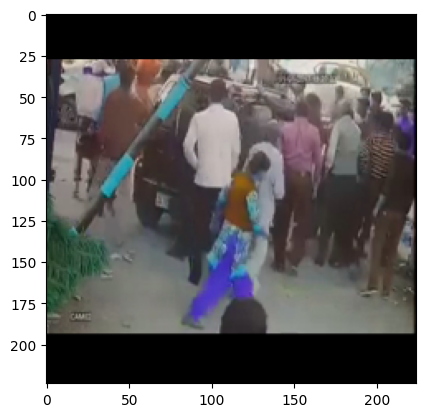

In [258]:
plt.imshow(frames.squeeze().numpy())

with skeleton

In [101]:
att_mat = model_l.blocks[0].attn.attn_scores

torch.Size([100, 8, 21, 21])

In [41]:
from torch.nn.functional import interpolate

att_mat = interpolate(att_mat, size=224 ,mode='nearest', align_corners=None, recompute_scale_factor=None, antialias=False)

In [42]:
att_mat.size()

torch.Size([1, 34, 224])

with ViT

In [183]:
torch.softmax(model_l.cross_attention_block.attn.cross_attn_scores,dim=1)

tensor([[[[0.2500],
          [0.2500],
          [0.2500],
          ...,
          [0.2500],
          [0.2500],
          [0.2500]],

         [[0.2500],
          [0.2500],
          [0.2500],
          ...,
          [0.2500],
          [0.2500],
          [0.2500]],

         [[0.2500],
          [0.2500],
          [0.2500],
          ...,
          [0.2500],
          [0.2500],
          [0.2500]],

         [[0.2500],
          [0.2500],
          [0.2500],
          ...,
          [0.2500],
          [0.2500],
          [0.2500]]],


        [[[0.2500],
          [0.2500],
          [0.2500],
          ...,
          [0.2500],
          [0.2500],
          [0.2500]],

         [[0.2500],
          [0.2500],
          [0.2500],
          ...,
          [0.2500],
          [0.2500],
          [0.2500]],

         [[0.2500],
          [0.2500],
          [0.2500],
          ...,
          [0.2500],
          [0.2500],
          [0.2500]],

         [[0.2500],
          [0.2500],

In [133]:
# att_mat = torch.mean(torch.s
# tack([model_l.model_2.encoder.layers.encoder_layer_0.attention_weight]).squeeze(1), dim=1)
att_mat = model_l.model_2.encoder.layers.encoder_layer_0.attention_weight

In [275]:
img_idx = 47

In [276]:
w,h = 28,28

In [286]:
att_mat_0 = att_mat[img_idx].detach()

In [287]:
att_mat_0 = torch.mean(att_mat_0[:,1:,1:],dim=0)

In [288]:
att_mat_0 = att_mat_0[2,:]

torch.Size([784])

In [264]:
attention = att_mat_0[1,1,1:]

IndexError: too many indices for tensor of dimension 1

In [289]:
attention = att_mat_0.reshape(28,28)

In [290]:
def show_img2(img1, img2, alpha=0.5):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.figure(figsize=(10, 10))
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha)
    plt.axis('off')
    plt.show()

In [291]:
attention = F.interpolate(attention.view(1, 1, 28, 28), (224, 224), mode='bilinear').view(224, 224, 1)

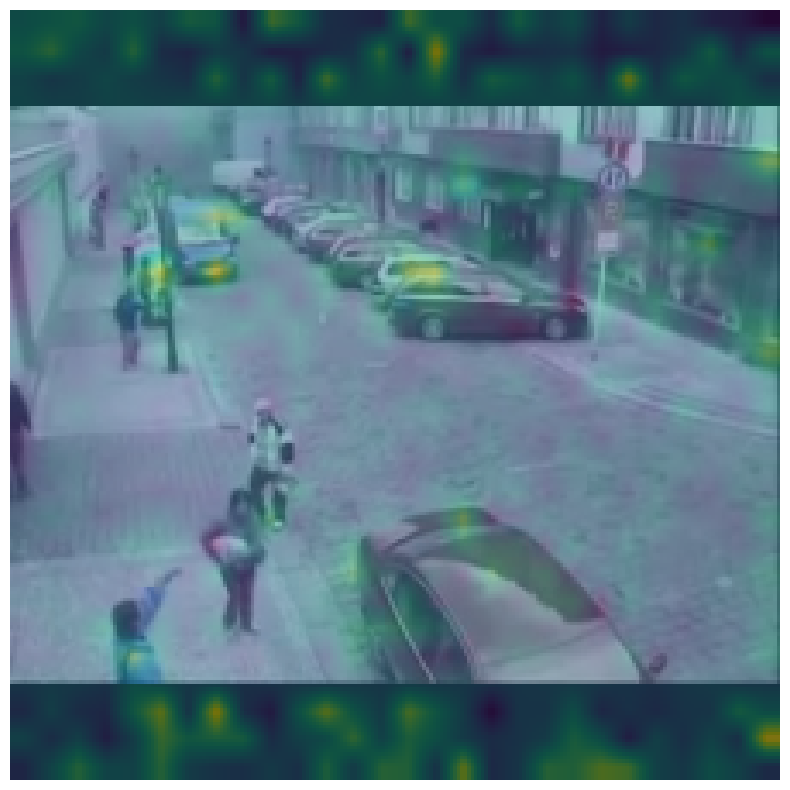

In [292]:
show_img2(frames[img_idx],attention)

In [183]:
filter = attention.reshape(28, 28)

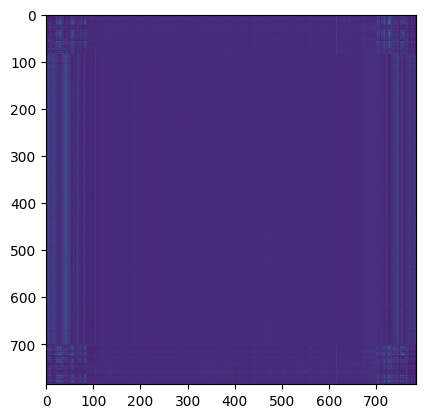

In [153]:
plt.imshow(att_mat_0[3])

https://www.cs.utexas.edu/~gdurrett/courses/sp2023/sample-research.pdf diufferent represntation

In [57]:
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image, ImageColor

In [120]:
def overlay_attention_weights(image_path, attention_weights, save_path):
    # Load the image
    # print(type(image_path))
    # print(image_path[])
    # img_array = image_path[0]
  
    image =  Image.fromarray((image_path[0] * 255).numpy().astype(np.uint8))
    
    # Choose one image's attention weights
    attention = attention_weights[0]  # Choose the first image
    
    # Reshape attention weights to match the spatial dimensions of the image
    resized_attention = attention.reshape(image.size[::-1])
    
    # Normalize attention weights between 0 and 1
    normalized_weights = (resized_attention - np.min(resized_attention)) / (np.max(resized_attention) - np.min(resized_attention))
    
    # Convert normalized weights to heatmap image
    heatmap = ImageColor.colormap("hot")(normalized_weights.flatten(), bytes=True)
    heatmap = Image.fromarray(heatmap, mode="RGB")
    heatmap = heatmap.resize(image.size, resample=Image.BICUBIC)
    
    # Blend the heatmap with the original image
    blended_image = Image.blend(image.convert("RGBA"), heatmap.convert("RGBA"), alpha=0.5)
    
    # Save or display the resulting image
    blended_image.save(save_path)
    blended_image.show()

In [116]:
frames[0].shape[::-1]

torch.Size([3, 224, 224])

In [111]:
torch.mean(attention[0],dim=0).size()

torch.Size([21, 1])

In [114]:
print(torch.mean(attention[0],dim=0)[0])

tensor([1.], grad_fn=<SelectBackward0>)


In [108]:
overlay_attention_weights(frames,attention,"/")

RuntimeError: shape '[224, 224]' is invalid for input of size 84

In [95]:
c = torch.randn(224,224,3).numpy()

In [101]:
Image.fromarray((frames[0]*255).numpy())

TypeError: Cannot handle this data type: (1, 1, 3), <f4

In [106]:
im = Image.fromarray((frames[0] * 255).numpy().astype(np.uint8))

In [57]:
def visualize_attention(model, img, patch_size, device):
    # make the image divisible by the patch size
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - \
        img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    attentions = model.get_last_selfattention(img.to(device))

    nh = attentions.shape[1]  # number of head

    # keep only the output patch attention
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(
        0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()


In [58]:
visualize_attention(a,torch.randn(3,224,224),16,'cpu')

AttributeError: 'ViT' object has no attribute 'get_last_selfattention'

In [52]:
a = ViT(224,16,12,30,2,8,40)

In [53]:
a(torch.randn(1,3,224,224))

torch.Size([1, 8, 197, 197])
torch.Size([1, 8, 197, 197])


tensor([[-0.9491,  0.9033, -0.1284, -0.6549,  0.0174, -0.2677,  0.6118, -0.1467,
         -0.1112,  0.7255, -0.1893,  0.4106]], grad_fn=<AddmmBackward0>)

In [ ]:
class ModifiedMultiHead(MultiheadAttention):
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
    def forward(self,)

In [26]:
vit_model = VisionTransformer(image_size= 224,
                patch_size= 16,
                num_layers= 4,
                num_heads= 3,
                hidden_dim= 120,
                mlp_dim= 40,
                dropout=   0.0,
                attention_dropout=   0.0,
                num_classes=  64,
            )

In [28]:
print(vit_model.encoder)

Encoder(
  (dropout): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (encoder_layer_0): EncoderBlock(
      (ln_1): LayerNorm((120,), eps=1e-06, elementwise_affine=True)
      (self_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=120, out_features=120, bias=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
      (ln_2): LayerNorm((120,), eps=1e-06, elementwise_affine=True)
      (mlp): MLPBlock(
        (0): Linear(in_features=120, out_features=40, bias=True)
        (1): GELU(approximate=none)
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=40, out_features=120, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (encoder_layer_1): EncoderBlock(
      (ln_1): LayerNorm((120,), eps=1e-06, elementwise_affine=True)
      (self_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=120, out_features=120, bias=True)
      )
      (dro

In [25]:
vit_model.encoder.layers.encoder_layer_0

NameError: name 'vit_model' is not defined

In [ ]:
plt.imshow()

In [68]:
model.blocks[0].attn.attn_scores[0,:,:].shape

torch.Size([8, 6, 6])

In [27]:
count = 0
for i in range(3):
    count+=model.blocks[0].attn.attn_scores.shape[1]

In [34]:
model.Torso_blocks[0].attn.attn_scores.shape

torch.Size([10, 8, 2, 2])

In [25]:
len(model.blocks)

4

In [28]:
print(count)

24


In [ ]:
attns = []
for i in range(4):
    attns.append(model.blocks[i].attn.attn_scores)
attns = torch.concat(attns)

In [ ]:
model.blocks[0].attn.attn_scores.shape

In [ ]:
torch.mean(attns,axis=1)

In [ ]:
attns[-1].

In [ ]:
model.blocks[0].attn.attn_scores

In [ ]:
# train_crime_trajectories_1 = {}
# train_crime_trajectories_1["Robbery034_0101"] = train_crime_trajectories["Robbery034_0101"]

In [ ]:
# train_crime_trajectories["Robbery014_0127"].coordinates.shape

In [ ]:
import cv2
import glob
import os
# images = [cv2.imread(image, 0) for image in glob.glob("*.png")]

# result = cv2.bitwise_and(images[0], images[1])
# for image in images[2:]:
#     result = cv2.bitwise_and(result, image)

# cv2.imshow('result', result)
# cv2.waitKey(0)

In [ ]:
import seaborn as sns

In [ ]:
path="/deepstore/datasets/dmb/MachineLearning/HRC/HRC_files/UCF_Videos"

In [ ]:
all_classes = os.listdir(path)

In [ ]:
x = []
y = []
for i in range(len(all_classes)):
    x.append(all_classes[i])
    y.append(len(os.listdir(os.path.join(path,all_classes[i]))))


In [ ]:
from matplotlib import pyplot as plt

In [ ]:
# sns.to("Total number of video per classes")
sns.set_style("whitegrid")

sns.barplot(y,x).set(title="Total number of videos per classes")
plt.savefig("no_videos_p_class.png",dpi=350)

In [ ]:
import numpy as np

In [1]:
trajectories_path="/deepstore/datasets/dmb/MachineLearning/HRC/HRC_files/dataverse_files/trajectories_all/"

In [ ]:
x = []
y = []
trajectory_p_video = []
for i in all_classes:
    full_path = os.path.join(trajectories_path,i) #accessing trajectory/classname
    peoples = os.listdir(full_path)
    for people in peoples:
        if not people.startswith('.'):

            people_path = os.path.join(full_path,people)
            trajectory_p_video.append(len(os.listdir(people_path)))
            # for trajectory in os.listdir(people_path):
            #         full_trajectory_path = os.path.join(people_path,trajectory)
            #         data = np.loadtxt(full_trajectory_path, delimiter=',',ndmin=2)
            #         # data = np.array(sorted(data,key=lambda x:x[0]))
            #         len_trajectory = data.shape[0]
            #         # if len_trajectory>1851:
            #         #     print(len_trajectory)
            #         #     print(i,people,trajectory)
            #         x.append(i)
            #         y.append(len_trajectory)



In [ ]:
# sns.title("Trajectory per video")
sns.boxplot(y=trajectory_p_video,width=0.09).set(title="Trajectory Per Video")
plt.savefig("trajectory_p_video.png",dpi=300)

In [ ]:
            # for trajectory in os.listdir(people_path):
            #         full_trajectory_path = os.path.join(people_path,trajectory)
            #         data = np.loadtxt(full_trajectory_path, delimiter=',',ndmin=2)
            #         # data = np.array(sorted(data,key=lambda x:x[0]))
            #         len_trajectory = data.shape[0]
            #         # if len_trajectory>1851:
            #         #     print(len_trajectory)
            #         #     print(i,people,trajectory)
            #         x.append(i)
            #         y.append(len_trajectory)



In [ ]:
max(y)

In [ ]:
sns.boxplot(y,x)

In [ ]:
ids = dataset[12509]["id"]

In [ ]:
getVideoFiles = ids[0]

videoDir =  getVideoFiles.split("_")[0][:-3] 

videofile = getVideoFiles.split("_")[0]+"_x264.mp4"

video_path = os.path.join(path,videoDir,videofile)

In [ ]:
print(video_path)